In [1]:
from utils.hparams import hparams,set_hparams
from preprocessing.data_gen_utils import get_pitch_parselmouth,get_pitch_crepe
from utils.pitch_utils import norm_interp_f0
from network.vocoders.base_vocoder import VOCODERS
from modules.fastspeech.pe import PitchExtractor
import numpy as np
from infer_tool import infer_tool
from preprocessing.hubertinfer import Hubertencoder
from network.diff.diffusion import GaussianDiffusion
from utils.pitch_utils import denorm_f0
from network.diff.net import DiffNet
from network.vocoders.base_vocoder import get_vocoder_cls, BaseVocoder
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import utils
import librosa
import resampy
import torchcrepe
import soundfile as sf
from utils.pitch_utils import f0_to_coarse

DIFF_DECODERS = {
    'wavenet': lambda hp: DiffNet(hp['audio_num_mel_bins'])
}
#===========这里填写checkpoints对应的exp_name(项目名,ckpt所在文件夹的名字),ckpt和config路径==========
_=set_hparams(config='./checkpoints/mxj/mxj_config.yaml', exp_name='mxj',infer=True,reset=True,hparams_str='', print_hparams=False)
modelpath='./checkpoints/mxj/model_ckpt_steps_188000.ckpt'
hparams['hubert_gpu']=True
#=============================================================
encoder=Hubertencoder(hparams['hubert_path'])
model = GaussianDiffusion(
        phone_encoder=encoder,
        out_dims=hparams['audio_num_mel_bins'], denoise_fn=DIFF_DECODERS[hparams['diff_decoder_type']](hparams),
        timesteps=hparams['timesteps'],
        K_step=hparams['K_step'],
        loss_type=hparams['diff_loss_type'],
        spec_min=hparams['spec_min'], spec_max=hparams['spec_max'],
    )
utils.load_ckpt(model,modelpath,'model',force=True, strict=True)
model.cuda()
pe = PitchExtractor().cuda()
utils.load_ckpt(pe, hparams['pe_ckpt'], 'model', strict=True)
pe.eval()
vocoder: BaseVocoder = get_vocoder_cls(hparams)()
inf=infer_tool(encoder,model,pe,vocoder)
print('model loaded')

e:\Codedata\anaconda\envs\diffsvc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| load 'model' from './checkpoints/mxj/model_ckpt_steps_188000.ckpt'.
| load 'model' from 'checkpoints/0102_xiaoma_pe/model_ckpt_steps_60000.ckpt'.
| load HifiGAN:  checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth
| Loaded model parameters from checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth.
| HifiGAN device: cuda.
model loaded


In [2]:
wav_fn='test_input.wav'
demoaudio,sr=librosa.load(wav_fn,sr=None)
tempdict=inf.make_dict(wav_fn,use_crepe=True,thre=0.05)

mel time used 0.13663387298583984
f0 (by parselmouth) time used 0.3959386348724365
hubert (on cuda) time used 7.561769485473633


In [3]:
hparams['pndm_speedup']=20
f0_tst,f0_pred,audio=inf.infer(tempdict,key=0,use_pe=True,use_gt_mel=False,add_noise_step=1000)
ipd.display(ipd.Audio(demoaudio, rate=sr))
ipd.display(ipd.Audio(audio, rate=24000, normalize=False))
import soundfile as sf
wav_gen='test_output.wav'
sf.write(wav_gen, audio, 24000, 'PCM_16')

===> gaussion start.


sample time step: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


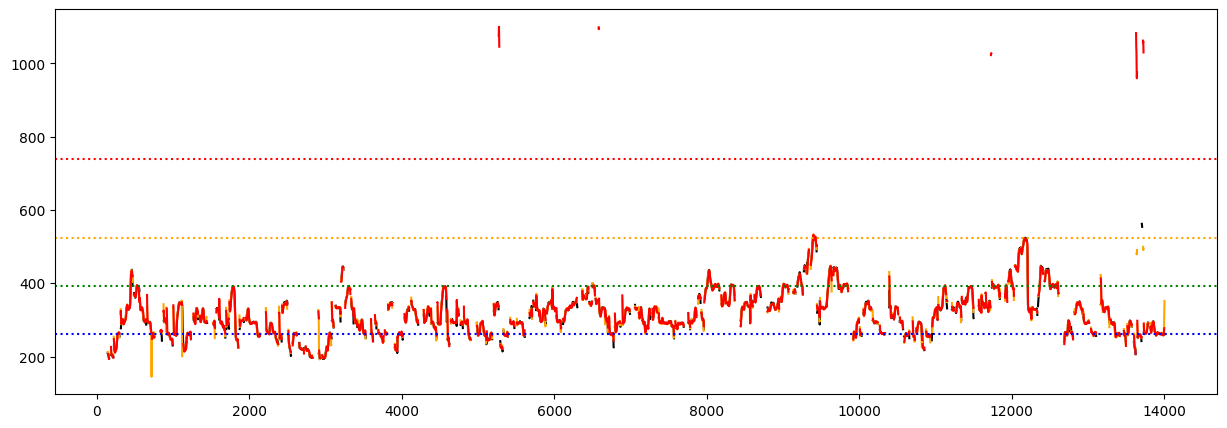

In [ ]:
#f0_gen,_=get_pitch_crepe(*vocoder.wav2spec(wav_gen),hparams,threshold=0.05)
f0_gen,_=get_pitch_parselmouth(*vocoder.wav2spec(wav_gen),hparams)
f0_tst[f0_tst==0]=np.nan#ground truth f0
f0_pred[f0_pred==0]=np.nan#f0 pe predicted
f0_gen[f0_gen==0]=np.nan#f0 generated
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0_tst)),f0_tst,color='black')
plt.plot(np.arange(0,len(f0_pred)),f0_pred,color='orange')
plt.plot(np.arange(0,len(f0_gen)),f0_gen,color='red')
plt.axhline(librosa.note_to_hz('C4'),ls=":",c="blue")
plt.axhline(librosa.note_to_hz('G4'),ls=":",c="green")
plt.axhline(librosa.note_to_hz('C5'),ls=":",c="orange")
plt.axhline(librosa.note_to_hz('F#5'),ls=":",c="red")
#plt.axhline(librosa.note_to_hz('A#5'),ls=":",c="black")
plt.show()
